In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from root_numpy import root2array
import Constants as C
from WeightTool import WeightTool
from matplotlib.colors import LogNorm

from PlotTool import PlotTool
from Cuts import qratio, getQAB, qlayerCut, maxDistMaxDoms, firstHitInOuter
from Loader import Loader

In [2]:
# Load the data 

nload = Loader(C.basesel)
hload = Loader('passHESE')

dt_new = nload.getNuE()
dt_hese = hload.getNuE()


In [5]:
# Apply q-layer cut
dt_new = qlayerCut(dt_new, False, 0.8)

# Cut on the first hit 
dt_new = firstHitInOuter(dt_new)

# Cut on rho travel
dt_new = dt_new[ dt_new['rho_travel'] < 500]

# Cut on z-travel
dt_new = dt_new[ (-500 < dt_new['hs_z_travel']) & (dt_new['hs_z_travel'] < 100) ]

# Cut on timing
dt_new = dt_new[ dt_new['tlarge5[0]-tearly5[0]'] < 2000 ]


In [ ]:
# Check that the yields look ok
print "New selection: ", sum(dt_new['wE2']) * 365/34.7
print "HESE:          ", sum(dt_hese['wE2']) * 365/34.7
print "PeV New:       ", sum(dt_new[ dt_new['PrimaryNeutrinoEnergy'] > 1000000]['wE2']) * 365/34.7


In [7]:
# Methods to plot effective area
from math import pi,log10

xmin  = 3
xmax  = 7
nbins = 20.
bins = np.arange(3,9.1,0.3)
ebins_per_decade = float(nbins/(xmax-xmin))
solidangle = 4*pi

def mcLogEBin(E):
    return int(log10(E)*ebins_per_decade)
def mcEMin(mc_log_ebin):
    return pow(10,mc_log_ebin/ebins_per_decade)
def mcEMax(mc_log_ebin):
    return pow(10,(1+mc_log_ebin)/ebins_per_decade)

# Calculate effective area
def getEffA(data):
    effA = np.zeros(len(data['PrimaryNeutrinoEnergy']),dtype=float)
    energy = np.empty(len(data['PrimaryNeutrinoEnergy']),dtype=float)        
    fnorm  = 1. / (C.nugen_nue_nfiles)
    
    dt_E = data['PrimaryNeutrinoEnergy'].as_matrix()
    dt_oneweight = data['OneWeight'].as_matrix()
    dt_nevents   = data['NEvents'].as_matrix()
    for i in range(len(effA)):

        E = dt_E[i]
        OneWeight = dt_oneweight[i]
        NEvents   = dt_nevents[i]
        mclogebin = mcLogEBin(E)
        mcemin = mcEMin(mclogebin)
        mcemax = mcEMax(mclogebin)
        
        effA[i] = 1e-4 * OneWeight * fnorm/NEvents * 1/(solidangle*(mcemax-mcemin))
        energy[i] = log10(E)

    return effA, energy

def plotEffA(nrg, effa, col, lbl,ls='solid'):
        plt.hist(nrg,
                 weights=effa,
                 color=col,
                 label=lbl,
                 range=(xmin,xmax),
                 bins = nbins,
                 histtype='step',
                 lw = 1.5,
                ls = ls)


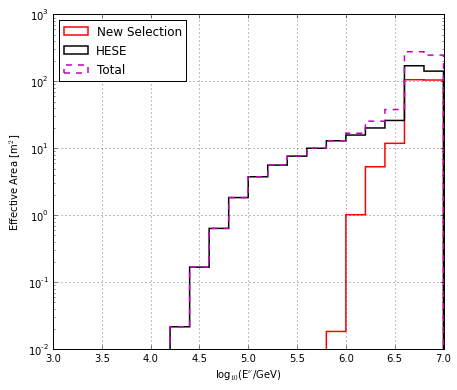

In [9]:
# Now plot the effective area
effA_new, e_new = getEffA(dt_new[ dt_new['log10(hs_q_tot_pulses)'] >= 5])
effA_hese, e_hese = getEffA(dt_hese)

fig, ax = plt.subplots(ncols=1,figsize=(7,6))
plotEffA(e_new, effA_new, 'r','New Selection')
plotEffA(e_hese,effA_hese,'black','HESE')
plotEffA(np.concatenate([e_hese,e_new]), 
         np.concatenate([effA_hese, effA_new]), 
         'm', "Total", 'dashed')

ax.set_ylim([1e-2,1e3])
ax.set_yscale('log')
plt.xlabel(r'log$_{10}$(E$^{\nu}$/GeV)')
plt.ylabel(r'Effective Area [m$^{2}$]')
plt.grid()

plt.legend(loc='upper left')
#plt.savefig('../plots/cutsana/EffectiveArea/firstpasssel.png')

